In [1]:
import numpy as np
import gensim
import pandas as pd
from matplotlib import pyplot as plt
import seaborn
import re
import statsmodels.formula.api
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
%matplotlib nbagg

In [7]:
def load_lexicon(filename):
    lexicon = []
    with open(filename) as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

pos_words = load_lexicon("data/opinion_lexicon/positive-words.txt")
neg_words = load_lexicon("data/opinion_lexicon/negative-words.txt")

In [2]:
df = pd.read_csv("data/kaggle_toxicity/train.csv")

In [3]:
df[df["identity_hate"]==1][:10]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
105,00472b8e2d38d1ea,A pair of jew-hating weiner nazi schmucks.,1,0,1,0,1,1
176,006b94add72ed61c,I think that your a Fagget get a oife and burn...,1,0,1,1,1,1
218,008e0818dde894fb,"Kill all niggers. \n\nI have hard, that others...",1,0,1,0,1,1
238,0097dd5c29bf7a15,u r a tw@ fuck off u gay boy.U r smelly.Fuck u...,1,0,1,0,1,1
429,01166f26ee280e56,Gay \n\nThe existence of CDVF is further proof...,1,0,1,0,1,1
521,015d1b0bb4cc744d,Dictionaries\n\nHow dare you call my contribut...,1,0,1,0,1,1
887,026bd33490542b2e,"you gay motherfucker i know where you live,i a...",1,1,1,0,1,1
952,029dceed3519e371,you studid cock sucker u stop callin me ok its...,1,0,1,0,1,1
1017,02c6e41e4b317ac3,WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'L...,1,1,1,1,1,1


<IPython.core.display.Javascript object>


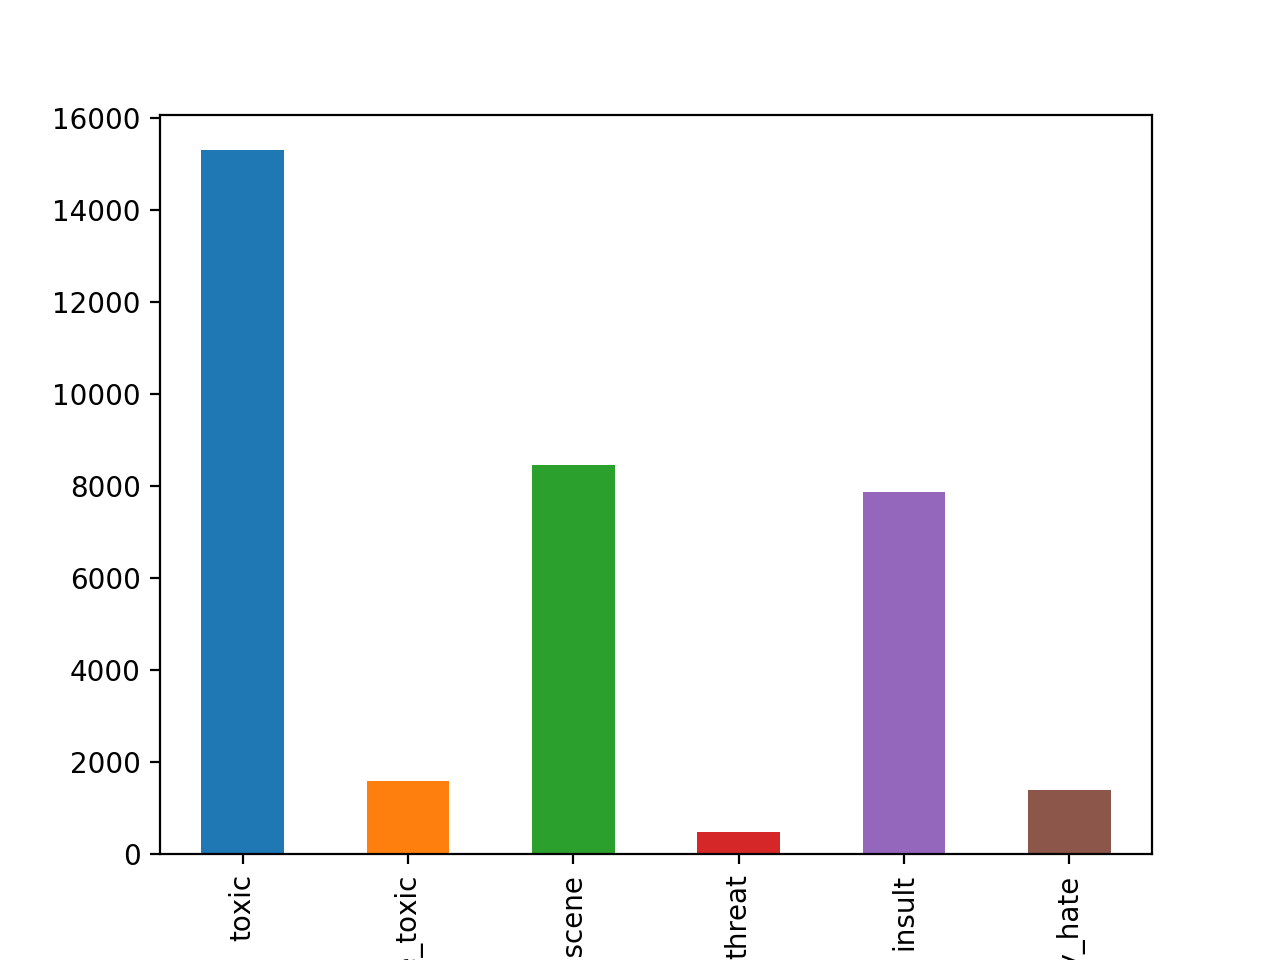

In [4]:
plt.figure()
df.sum(numeric_only=True).plot("bar")

In [5]:
a = df[df["toxic"]==1].comment_text.tolist()
from collections import Counter
import re

counts = Counter()
words = re.compile(r'\w+')

for sentence in a:
    counts.update(words.findall(sentence.lower()))

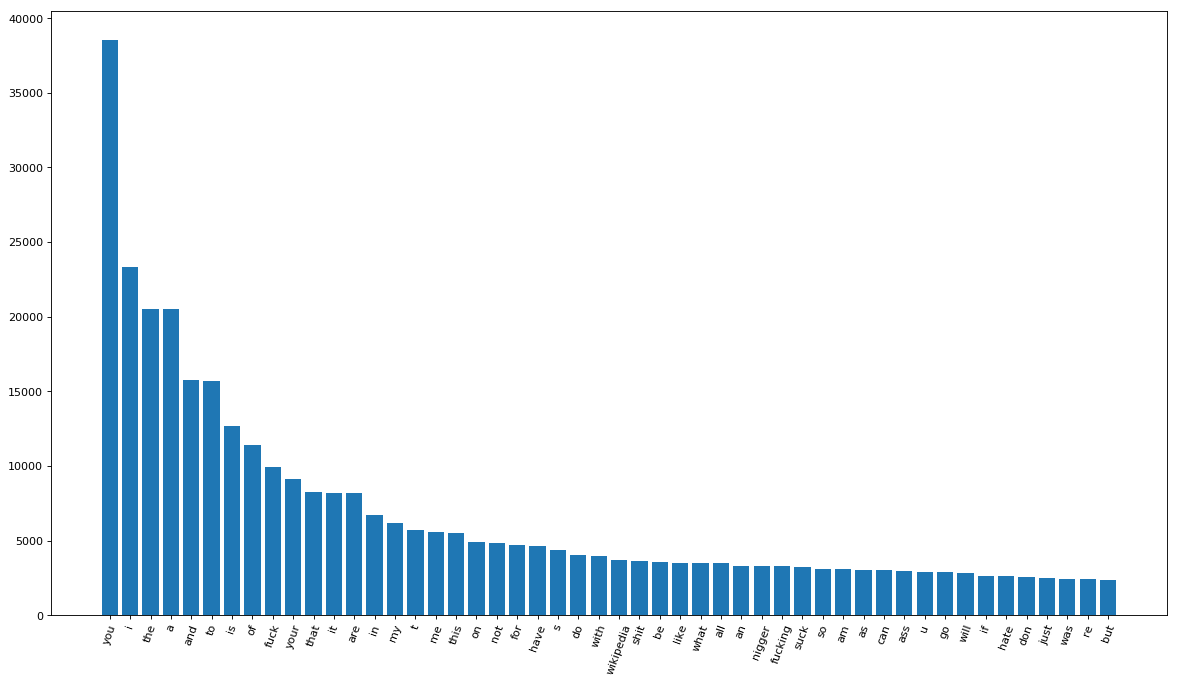

In [9]:
%matplotlib inline
plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
a,b = zip(*counts.most_common(50))
index = np.arange(len(a))
plt.bar(index,b)
plt.xticks(index, a, fontsize=10, rotation=70)
plt.show()

In [10]:
embeddings = gensim.models.KeyedVectors.load_word2vec_format('data/embeddings/GoogleNews-vectors-negative300.bin.gz', binary=True)
# embeddings = gensim.models.KeyedVectors.load_word2vec_format('data/embeddings/2017_wiki_dump/model.txt')
# embeddings = gensim.models.KeyedVectors.load_word2vec_format('data/glove.6B/glove.6B.300d.txt')
print "number of word vectors: ", len(embeddings.wv.vocab)

number of word vectors:  3000000


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


In [11]:
def generate_train_test_set(model,targets,sentences,limit=1000,dim=300):
    vectors = np.zeros((29697,dim))
    labels = np.zeros((29697))
    count=0
    for i,sentence in enumerate(sentences):
        words = filter(lambda x: x in model,[x.lower() for x in sentence.split()])
        if len(words)>2:
            vectors[count,:] = np.mean(model[words],axis = 0)
            labels[count] = targets[i] 
            count+=1
    print count, " sentences in embeddings, ", limit - count, " sentences not in embeddings"
    return train_test_split(vectors, labels, test_size=0.1, random_state=0)

Race.
Color.
Religion or creed.
National origin or ancestry.
Sex.
Age.
Physical or mental disability.
Veteran status.
Genetic information.
Citizenship.

In [12]:
len(neg_words)

NameError: name 'neg_words' is not defined

In [15]:
pos_words = filter(lambda x:  x in embeddings,pos_words)
neg_words = filter(lambda x:  x in embeddings,neg_words)

In [22]:
pos_vectors = embeddings[pos_words]
neg_vectors = embeddings[neg_words]
vectors = np.concatenate([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors] + [-1 for entry in neg_vectors])
labels = list(pos_vectors) + list(neg_vectors)
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

In [13]:
toxic_sentences = df[df["toxic"]==1]["comment_text"]
num_toxic_samples = len(toxic_sentences)
non_toxic_sentences = df[df["toxic"]==0]["comment_text"].sample(num_toxic_samples)
sentences = pd.concat([toxic_sentences, non_toxic_sentences])
targets  = np.zeros(num_toxic_samples*2)
targets[num_toxic_samples:] = 1
train_vectors, test_vectors, train_targets, test_targets = generate_train_test_set(embeddings,targets,sentences,limit=num_toxic_samples*2 ,dim=300)

29686  sentences in embeddings,  902  sentences not in embeddings


In [20]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True, verbose=False):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
        self.verbose = verbose
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        # weights initialization
        self.theta = np.zeros(X.shape[1])
        def calculate_gradient(self, X, Y, beta):

        if type(Y) is np.ndarray:
            data_num = len(Y)
            original_X = X[:, 1:]
            K = utility.Kernel.kernel_matrix(self, original_X)
        else:
            data_num = 1
            original_x = X[1:]
            original_X = self.train_X[:, 1:]
            K = utility.Kernel.kernel_matrix_xX(self, original_x, original_X)

        gradient_average = ((2 * self.lambda_p) / data_num) * np.dot(beta, K) + 
        np.dot(self.theta((-1) * Y * np.dot(beta, K)) * ((-1) * Y), K) / data_num
        
        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * gradient
            
            if(self.verbose == True and i % 10000 == 0):
                z = np.dot(X, self.theta)
                h = self.__sigmoid(z)
                print 'loss: {self.__loss(h, y)} \t'
    
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X, threshold):
        return self.predict_prob(X) >= threshold

In [23]:
model = LogisticRegression(lr=0.1, num_iter=3000,verbose=True)
%time model.fit(train_vectors, train_targets)

NameError: name 'LogisticRegression' is not defined

In [28]:
preds = model.predict(test_vectors,.5)
# accuracy
(preds == test_targets).mean()

0.80909090909090908

In [62]:
from sklearn import svm
clf = svm.SVC(kernel='linear', gamma=2,probability=True)
clf.fit(train_vectors, train_targets)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=2, kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [94]:
preds = clf.predict(test_vectors)
# accuracy
(preds == test_targets).mean()

0.8609427609427609

In [144]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(train_vectors)
principalComponents1 = pca.transform(test_vectors)

# principalDf = pd.DataFrame(data = principalComponents
#              , columns = ['principal component 1', 'principal component 2'])

In [87]:
finalDf = pd.concat([principalDf, pd.Series(train_targets)], axis = 1)

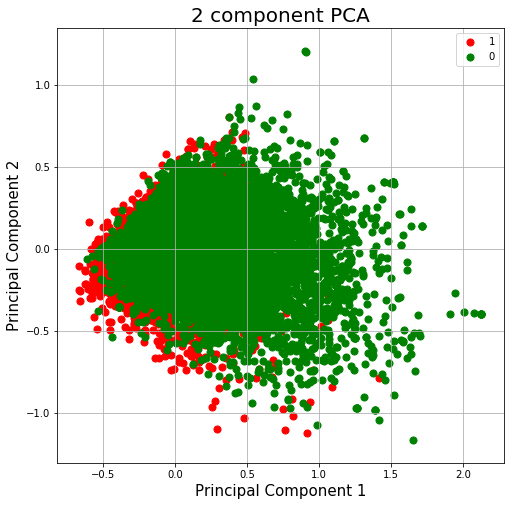

In [93]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1, 0]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf[0] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [145]:
from sklearn import svm
clf1 = svm.SVC(kernel='linear', gamma=2,probability=True)
clf1.fit(principalComponents, train_targets)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=2, kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [146]:
preds = clf1.predict(principalComponents1)
# accuracy
(preds == test_targets).mean()

0.83367003367003367

In [147]:
text_to_toxicity(clf1,embeddings,"hello bitch")

0.99999940217022687

In [148]:
def words_to_toxicity(model,embeddings,words):
    words = filter(lambda x: x in embeddings,[x.lower() for x in words])
    if len(words)>0:
        vector = np.mean(embeddings[words],axis = 0)
        prob = model.predict_proba(pca.transform([vector]))
        return prob[0][0]
    else: return 0;

In [149]:
def text_to_toxicity(model,embeddings,text):
    tokens = text.split()
    toxicity = words_to_toxicity(model,embeddings,tokens)
    return toxicity

In [150]:
identities = ['lesbian', 'gay', 'bisexual', 'transgender', 'trans', 'queer', 'lgbt', 'lgbtq', 'homosexual', 'straight', 'heterosexual', 'male', 'female', 'nonbinary', 'african', 'african american', 'black', 'white', 'european', 'hispanic', 'latino', 'latina', 'latinx', 'mexican', 'canadian', 'american', 'asian', 'indian', 'middle eastern', 'chinese', 'japanese', 'christian', 'muslim', 'jewish', 'buddhist', 'catholic', 'protestant', 'sikh', 'taoist', 'old', 'older', 'young', 'younger', 'teenage', 'millenial', 'middle aged', 'elderly', 'blind', 'deaf', 'paralyzed']

In [151]:
def identity_toxicity_table():
    words = []
    toxicities = []
    for word in sorted(identities):
        if word in embeddings:
            toxicities.append(text_to_toxicity(clf1, embeddings,word.lower()))
            words.append(word)
    toxicities, words = zip(*sorted(zip(toxicities, words),key=lambda x : x[0]))
    return toxicities, words

identity_toxicity = identity_toxicity_table()

In [152]:
np.var(identity_toxicity[0])

0.022676335684669206

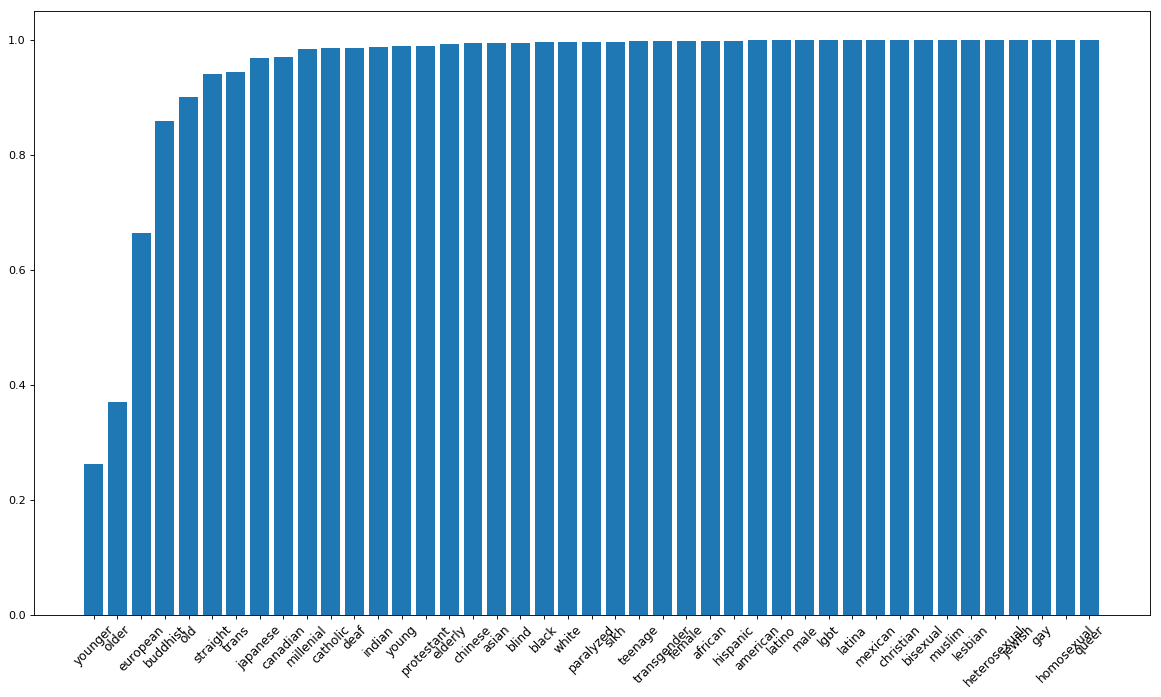

In [153]:
%matplotlib inline
plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
index = np.arange(len(identity_toxicity[1]))
plt.bar(index,identity_toxicity[0])
plt.xticks(index, identity_toxicity[1], fontsize=11, rotation=45)
plt.show()

In [74]:
clf.predict_proba([embeddings["blind"]])

array([[  9.99739637e-01,   2.60363398e-04]])